The following script takes you through the steps of retrieving an Upper Air vertical profile from an AWIPS EDEX server and plotting a Skew-T/Log-P chart with Matplotlib and MetPy.

The **bufrua** plugin returns separate objects for parameters at **mandatory levels** and at **significant temperature levels**.  For the Skew-T/Log-P plot, significant temperature levels are used to plot the pressure, temperature, and dewpoint lines, while mandatory levels are used to plot the wind profile.

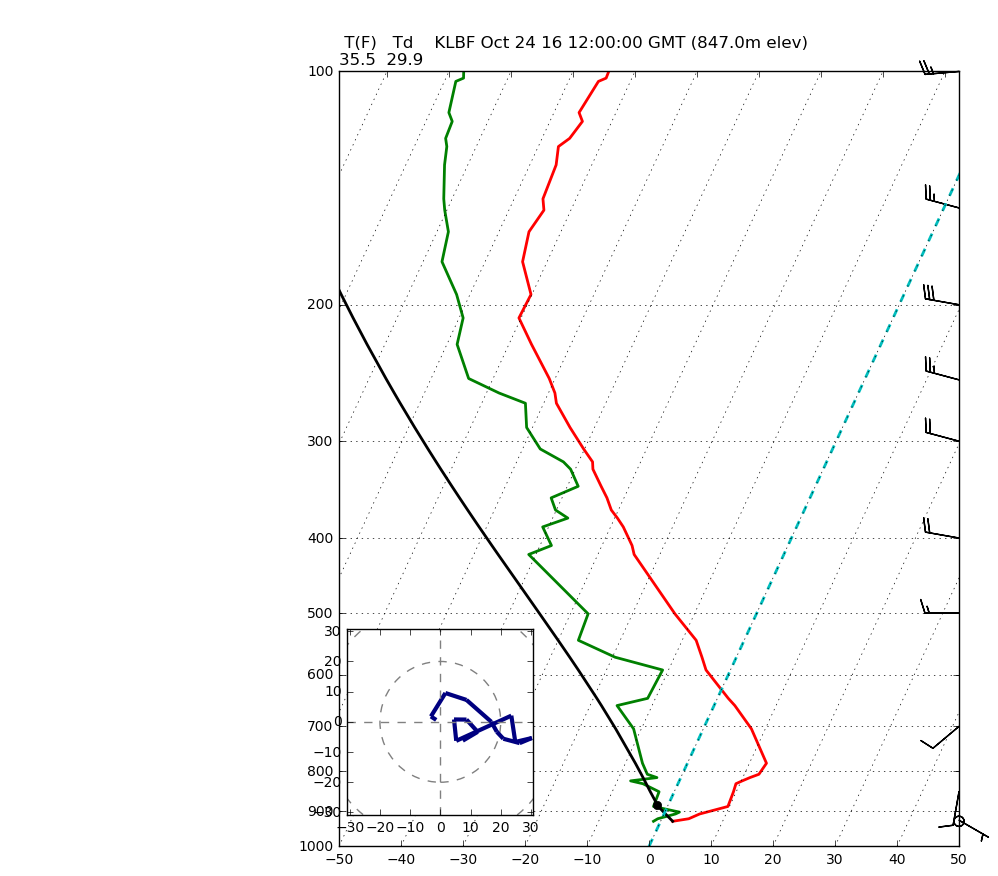

In [65]:
%matplotlib inline
from awips.dataaccess import DataAccessLayer
import matplotlib.tri as mtri
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
import math
from metpy.calc import get_wind_speed, get_wind_components, lcl, dry_lapse, parcel_profile
from metpy.plots import SkewT, Hodograph
from metpy.units import units, concatenate

# Set host
DataAccessLayer.changeEDEXHost("edex-cloud.unidata.ucar.edu")
request = DataAccessLayer.newDataRequest()

# Set data type
request.setDatatype("bufrua")
availableLocs = DataAccessLayer.getAvailableLocationNames(request)
availableLocs.sort()

# Set Mandatory and Significant Temperature level parameters
MAN_PARAMS = set(['prMan', 'htMan', 'tpMan', 'tdMan', 'wdMan', 'wsMan'])
SIGT_PARAMS = set(['prSigT', 'tpSigT', 'tdSigT'])
request.setParameters("wmoStaNum", "validTime", "rptType", "staElev", "numMand",
                      "numSigT", "numSigW", "numTrop", "numMwnd", "staName")
request.getParameters().extend(MAN_PARAMS)
request.getParameters().extend(SIGT_PARAMS)

# Set station ID (not name)
request.setLocationNames("72562") #KLBF

# Get all times
datatimes = DataAccessLayer.getAvailableTimes(request)

# Get most recent record
response = DataAccessLayer.getGeometryData(request,times=datatimes[-1].validPeriod)

# Initialize data arrays
tdMan,tpMan,prMan,wdMan,wsMan = np.array([]),np.array([]),np.array([]),np.array([]),np.array([])
prSig,tpSig,tdSig = np.array([]),np.array([]),np.array([])
manGeos = []
sigtGeos = []

# Build  arrays
for ob in response:
    if set(ob.getParameters()) & MAN_PARAMS:
        manGeos.append(ob)
        prMan = np.append(prMan,ob.getNumber("prMan"))
        tpMan = np.append(tpMan,ob.getNumber("tpMan"))
        tdMan = np.append(tdMan,ob.getNumber("tdMan"))
        wdMan = np.append(wdMan,ob.getNumber("wdMan"))
        wsMan = np.append(wsMan,ob.getNumber("wsMan"))
        continue
    if set(ob.getParameters()) & SIGT_PARAMS:
        sigtGeos.append(ob)
        prSig = np.append(prSig,ob.getNumber("prSigT"))
        tpSig = np.append(tpSig,ob.getNumber("tpSigT"))
        tdSig = np.append(tdSig,ob.getNumber("tdSigT"))
        continue

# Sort mandatory levels (but not sigT levels) because of the 1000.MB interpolation inclusion
ps = prMan.argsort()[::-1]
wpres = prMan[ps]
direc = wdMan[ps]
spd   = wsMan[ps]
tman = tpMan[ps]
dman = tdMan[ps]

# Flag missing data
prSig[prSig <= -9999] = np.nan
tpSig[tpSig <= -9999] = np.nan
tdSig[tdSig <= -9999] = np.nan
wpres[wpres <= -9999] = np.nan
tman[tman <= -9999] = np.nan
dman[dman <= -9999] = np.nan
direc[direc <= -9999] = np.nan
spd[spd <= -9999] = np.nan

# assign units
p = (prSig/100) * units.mbar
T = (tpSig-273.15) * units.degC
Td = (tdSig-273.15) * units.degC
wpres = (wpres/100) * units.mbar
tman = tman * units.degC
dman = dman * units.degC
u,v = get_wind_components(spd, np.deg2rad(direc))

# Create SkewT/LogP
plt.rcParams['figure.figsize'] = (8, 10)
skew = SkewT()
skew.plot(p, T, 'r', linewidth=2)
skew.plot(p, Td, 'g', linewidth=2)
skew.plot_barbs(wpres, u, v)
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-30, 30)

title_string = " T(F)   Td   " 
title_string +=  " " + str(ob.getString("staName"))
title_string += " " + str(ob.getDataTime().getRefTime())
title_string += " (" + str(ob.getNumber("staElev")) + "m elev)"
title_string += "\n" + str(round(T[0].to('degF').item(),1))
title_string += "  " + str(round(Td[0].to('degF').item(),1))
plt.title(title_string, loc='left')

# Calculate LCL height and plot as black dot
l = lcl(p[0], T[0], Td[0])
lcl_temp = dry_lapse(concatenate((p[0], l)), T[0])[-1].to('degC')
skew.plot(l, lcl_temp, 'ko', markerfacecolor='black')

# Calculate full parcel profile and add to plot as black line
prof = parcel_profile(p, T[0], Td[0]).to('degC')
skew.plot(p, prof, 'k', linewidth=2)

# An example of a slanted line at constant T -- in this case the 0 isotherm
l = skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)

# Draw hodograph
ax_hod = inset_axes(skew.ax, '30%', '30%', loc=3)
h = Hodograph(ax_hod, component_range=max(wsMan))
h.add_grid(increment=20)
h.plot_colormapped(u, v, spd)

# Show the plot
plt.show()